In [1]:
import sys, os
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession, Catalog
from pyspark.sql import DataFrame, DataFrameStatFunctions, DataFrameNaFunctions
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.types import Row
from subprocess import check_output

SPARK_DRIVER_HOST = check_output(["hostname", "-i"]).decode(encoding="utf-8").strip()
spark_conf = SparkConf()
spark_conf.setAll([
    ('spark.master', 'spark://spark:7077'),
    ('spark.app.name', 'myApp'),
    ('spark.submit.deployMode', 'client'),
    ('spark.ui.showConsoleProgress', 'true'),
    ('spark.eventLog.enabled', 'false'),
    ('spark.logConf', 'false'),
    ('spark.driver.bindAddress', '0.0.0.0'),
    ('spark.driver.host', SPARK_DRIVER_HOST),
    ('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.2.0,com.amazonaws:aws-java-sdk-bundle:1.11.704,org.apache.spark:spark-hadoop-cloud_2.12:3.3.0'),
    ("spark.hadoop.fs.s3a.endpoint", 'http://minio:9000'),
    ('spark.hadoop.fs.s3a.access.key', 'minio-root-user'),
    ('spark.hadoop.fs.s3a.secret.key', 'minio-root-password'),
    ('spark.hadoop.fs.s3a.bucket.all.committer.magic.enabled', True),
    ("spark.hadoop.fs.s3a.fast.upload", True),
    ("spark.hadoop.fs.s3a.path.style.access", True),
    ("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
])
 
spark_sess          = SparkSession.builder.config(conf=spark_conf).getOrCreate()
spark_ctxt          = spark_sess.sparkContext
spark_reader        = spark_sess.read
spark_streamReader  = spark_sess.readStream
spark_ctxt.setLogLevel("WARN")

heartDF = spark_sess.read.option("header",True).option("inferSchema", True).csv('s3a://heart/heart.csv')
heartDF.show(truncate=False)

:: loading settings :: url = jar:file:/opt/bitnami/spark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk-bundle added as a dependency
org.apache.spark#spark-hadoop-cloud_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-df295d21-78b4-4379-88c5-47c793dcf9f1;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.0 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.704 in central
	found org.apache.spark#spark-hadoop-cloud_2.12;3.3.0 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.2 in central
	found org.apache.hadoop#hadoop-client-api;3.3.2 in central
	found org.xerial.snappy#snappy-java;1.1.8.4 in central
	found org.slf4j#slf4j-api;1.7.32 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.hadoop#hadoop-aws;3.3.2 in central
	found com.amazonaws#aws-java-sdk-bund

22/10/04 23:19:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/04 23:19:03 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex|cp |trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope|ca |thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|63 |1  |3  |145     |233 |1  |0      |150    |0    |2.3    |0    |0  |1   |1     |
|37 |1  |2  |130     |250 |0  |1      |187    |0    |3.5    |0    |0  |2   |1     |
|41 |0  |1  |130     |204 |0  |0      |172    |0    |1.4    |2    |0  |2   |1     |
|56 |1  |1  |120     |236 |0  |1      |178    |0    |0.8    |2    |0  |2   |1     |
|57 |0  |0  |120     |354 |0  |1      |163    |1    |0.6    |2    |0  |2   |1     |
|57 |1  |0  |140     |192 |0  |1      |148    |0    |0.4    |1    |0  |1   |1     |
|56 |0  |1  |140     |294 |0  |0      |153    |0    |1.3    |1    |0  |2   |1     |
|44 |1  |1  |120     |263 |0  |1      |173    |0    |0.0    |2    |0  |3   |1     |
|52 |1  |2  |172     |199 |1  |1      |162    |0    |0.5    |2    |0  |3   |

In [2]:
from pyspark.ml.feature import VectorAssembler

In [3]:
assembler = VectorAssembler(inputCols = ["age", "sex", "cp", "trestbps", "chol", \
         "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal"], outputCol = 'features')
assembledFrame = assembler.transform(heartDF)
assembledFrame.show()


22/10/04 23:20:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+--------------------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|            features|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+--------------------+
| 63|  1|  3|     145| 233|  1|      0|    150|    0|    2.3|    0|  0|   1|     1|[63.0,1.0,3.0,145...|
| 37|  1|  2|     130| 250|  0|      1|    187|    0|    3.5|    0|  0|   2|     1|[37.0,1.0,2.0,130...|
| 41|  0|  1|     130| 204|  0|      0|    172|    0|    1.4|    2|  0|   2|     1|[41.0,0.0,1.0,130...|
| 56|  1|  1|     120| 236|  0|      1|    178|    0|    0.8|    2|  0|   2|     1|[56.0,1.0,1.0,120...|
| 57|  0|  0|     120| 354|  0|      1|    163|    1|    0.6|    2|  0|   2|     1|[5

In [6]:
pandasFrame = assembledFrame.toPandas()

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

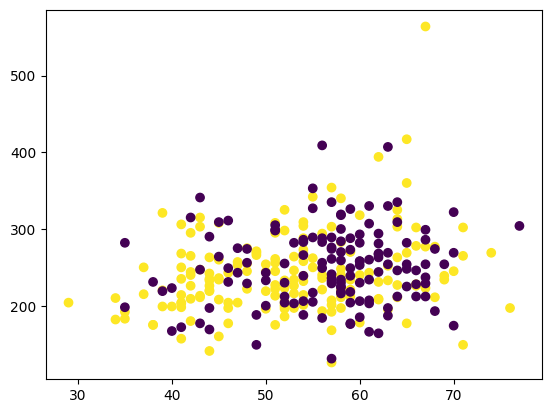

In [10]:
plt.scatter(pandasFrame.age, pandasFrame.chol, c=pandasFrame.target)

In [15]:
from pyspark.ml.classification import DecisionTreeClassifier

In [16]:
decisionTreeClassifier = DecisionTreeClassifier()

In [11]:
splitData = assembledFrame.randomSplit([0.7, 0.3], 1234)
trainingData = splitData[0]
testingData = splitData[1]

trainingData.show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+--------------------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|            features|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+--------------------+
| 34|  1|  3|     118| 182|  0|      0|    174|    0|    0.0|    2|  0|   2|     1|[34.0,1.0,3.0,118...|
| 35|  0|  0|     138| 183|  0|      1|    182|    0|    1.4|    2|  0|   2|     1|[35.0,0.0,0.0,138...|
| 35|  1|  0|     126| 282|  0|      0|    156|    1|    0.0|    2|  0|   3|     0|[35.0,1.0,0.0,126...|
| 35|  1|  1|     122| 192|  0|      1|    174|    0|    0.0|    2|  0|   2|     1|[35.0,1.0,1.0,122...|
| 37|  0|  2|     120| 215|  0|      1|    170|    0|    0.0|    2|  0|   2|     1|[37.0,0.0,2.0,120...|
| 37|  1|  2|     130| 250|  0|      1|    187|    0|    3.5|    0|  0|   2|     1|[37.0,1.0,2.0,130...|
| 38|  1|  2|     138| 175|  0|      1|    173|    0|  

In [12]:
nf = trainingData.select('features', 'target').withColumnRenamed('target', 'label')
nf.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[34.0,1.0,3.0,118...|    1|
|[35.0,0.0,0.0,138...|    1|
|[35.0,1.0,0.0,126...|    0|
|[35.0,1.0,1.0,122...|    1|
|[37.0,0.0,2.0,120...|    1|
|[37.0,1.0,2.0,130...|    1|
|[38.0,1.0,2.0,138...|    1|
|[38.0,1.0,2.0,138...|    1|
|[38.0,1.0,3.0,120...|    0|
|[39.0,0.0,2.0,94....|    1|
|[39.0,0.0,2.0,138...|    1|
|[39.0,1.0,0.0,118...|    0|
|[39.0,1.0,2.0,140...|    1|
|[40.0,1.0,0.0,110...|    0|
|[40.0,1.0,0.0,152...|    0|
|[40.0,1.0,3.0,140...|    1|
|[41.0,0.0,1.0,105...|    1|
|[41.0,0.0,1.0,126...|    1|
|[41.0,0.0,2.0,112...|    1|
|(13,[0,1,3,4,7,10...|    0|
+--------------------+-----+
only showing top 20 rows



In [17]:
model = decisionTreeClassifier.fit(dataset=nf)

In [18]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="target",rawPredictionCol="rawPrediction")

In [19]:
result = model.transform(testingData)
result.show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+--------------------+-------------+--------------------+----------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|            features|rawPrediction|         probability|prediction|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+--------------------+-------------+--------------------+----------+
| 29|  1|  1|     130| 204|  0|      0|    202|    0|    0.0|    2|  0|   2|     1|[29.0,1.0,1.0,130...|   [2.0,53.0]|[0.03636363636363...|       1.0|
| 34|  0|  1|     118| 210|  0|      1|    192|    0|    0.7|    2|  0|   2|     1|[34.0,0.0,1.0,118...|   [2.0,53.0]|[0.03636363636363...|       1.0|
| 35|  1|  0|     120| 198|  0|      1|    130|    1|    1.6|    1|  0|   3|     0|[35.0,1.0,0.0,120...|   [12.0,0.0]|           [1.0,0.0]|       0.0|
| 41|  0|  1|     130| 204|  0|      0|    172|    0|    1.4|    2|  0|   2|     1|[41.0,0.0,1

In [20]:
aucScore = evaluator.evaluate(result)
aucScore

0.8213675213675213